#### importing the library 

In [199]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [200]:
### device agnostic code for device 
device = "cuda"  if torch.cuda.is_available() else "cpu"
device

'cuda'

In [201]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [202]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)


In [203]:
X_blob.dtype , type(X_blob)

(dtype('float64'), numpy.ndarray)

In [204]:
### converting data into tensor
#  Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])


In [205]:
print(X_blob[:5]),print(y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]])
tensor([3, 2, 2, 1, 1])


(None, None)

In [206]:
## spliting the data into training and testing set
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

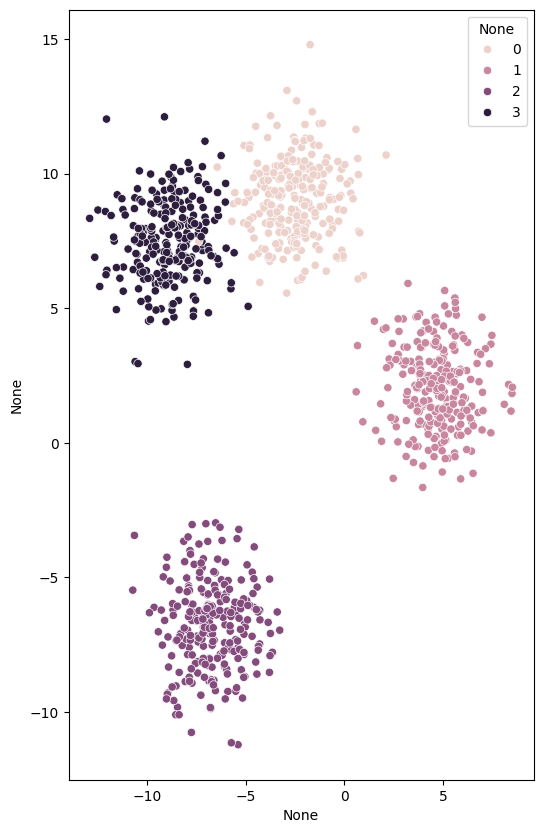

In [207]:
### plot the data 
plt.figure(figsize=(6,10))
sns.scatterplot(x=X_blob[:,0],
                y=X_blob[:,1],
                hue=y_blob)
plt.show()

## Building the multi-class classification model in Pytorch

In [208]:
## building the model
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
       
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)


In [209]:
device

'cuda'

In [210]:
# Create an instance of BlobModel and send it to the target device
model_0 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_0

In [211]:
model_0.state_dict()

OrderedDict([('linearlayer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='cuda:0')),
             ('linearlayer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='cuda:0')),
             ('linearlayer_stack.1.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.14

In [212]:
## creating the loss function and optimizer for multi-class Pytorch model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr = 0.01)

### Geting prediction probability for multi-class pytorch model
befor we train let's do a single forward pass with our model to see if it works.


In [213]:
type(X_blob_train)

torch.Tensor

In [214]:
device

'cuda'

In [215]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_0(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [216]:

# How many elements in a single prediction sample?
model_0(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

we go from `logits -> prediction probabilities -> prediction labels`

In [217]:

# Make prediction logits with model
y_logits = model_0(X_blob_test.to(device))

In [218]:
y_logits[:5], y_logits.ndimension()

(tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
         [ 1.7168, -1.2270,  1.7367,  2.1010],
         [ 2.2400,  0.7714,  2.6020,  1.0107],
         [-0.7993, -0.3723, -0.9138, -0.5388],
         [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 2)

In [219]:
# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [220]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

check which index has the highest value using torch.argmax().

In [221]:
y_pred_prob[0]

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [222]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [223]:
## acuracy calcultion
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    return correct/len(y_pred)*100

### Creating the training and testing loop for a multi-class pytorch model

In [224]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch : 0 | Loss : 1.04324 , Acc:65.50% | test Loss : 0.96335, test acc : 71.00%
Epoch : 10 | Loss : 0.63688 , Acc:79.50% | test Loss : 0.61222, test acc : 88.00%
Epoch : 20 | Loss : 0.46945 , Acc:97.75% | test Loss : 0.45865, test acc : 98.00%
Epoch : 30 | Loss : 0.37339 , Acc:98.50% | test Loss : 0.36771, test acc : 99.00%
Epoch : 40 | Loss : 0.31009 , Acc:98.62% | test Loss : 0.30659, test acc : 99.00%
Epoch : 50 | Loss : 0.26486 , Acc:98.88% | test Loss : 0.26227, test acc : 99.00%
Epoch : 60 | Loss : 0.23082 , Acc:98.88% | test Loss : 0.22853, test acc : 99.50%
Epoch : 70 | Loss : 0.20429 , Acc:99.12% | test Loss : 0.20197, test acc : 99.50%
Epoch : 80 | Loss : 0.18307 , Acc:99.12% | test Loss : 0.18057, test acc : 99.00%
Epoch : 90 | Loss : 0.16578 , Acc:99.12% | test Loss : 0.16301, test acc : 99.00%


## making the evaluation prediction with pytorch multi-class model 


In [225]:
# Make predictions
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 0.6728,  2.8048, -5.8948, -3.6846],
        [ 3.1247, -4.3091,  1.2266,  4.8820],
        [-0.3193, -3.6616,  8.5252,  4.9316],
        [ 0.1084,  2.1751, -3.3363, -2.7251],
        [ 2.6332,  0.2090, -5.9259, -0.8331],
        [ 3.6064, -5.2834,  1.8419,  6.0177],
        [-0.7624, -2.6307,  7.7098,  3.7128],
        [ 2.6994, -0.9662, -3.9135,  0.6692],
        [ 0.2015, -5.3148, 10.3011,  6.9350],
        [ 2.6329, -0.5243, -4.5675,  0.1151],
        [ 2.7021, -1.5655, -2.8105,  1.4435],
        [ 0.5758,  3.3736, -6.7087, -4.3951],
        [ 2.7376, -0.1477, -5.5231, -0.3989],
        [ 2.9867, -0.8435, -4.8495,  0.4366],
        [ 3.1240, -0.6654, -5.5179,  0.1711],
        [ 2.9488, -3.6018,  0.3510,  4.0128],
        [ 3.1757, -4.4979,  1.4503,  5.1130],
        [ 0.4781, -3.0883,  5.4963,  3.9851],
        [ 3.6296, -4.5816,  0.4851,  5.1043],
        [ 2.8580, -4.7536,  2.7073,  5.5254],
        [ 3.2575, -3.7199, -0.1922,  4.0859],
        [ 2.2942, -1.0162, -2.8212

In [226]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

 Predictions : tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Lables : tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy : 99.0%


## classification evaluation metrics

In [227]:
try:
    from torchmetrics import Accuracy
except:
    #pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9900, device='cuda:0')